In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import cv2
#import consine_similarity to find similarity between images
from sklearn.metrics.pairwise import cosine_similarity
#import flatten 2-D array
from pandas.core.common import flatten

import torch
import torch.nn as nn

import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

from PIL import Image

import warnings
warnings.filterwarnings("ignore")

### Import MetaData and Images

In [13]:
import pandas as pd

df = pd.read_csv('fashion-product-images-small/styles.csv', on_bad_lines='skip')
df.head(10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


<Axes: ylabel='articleType'>

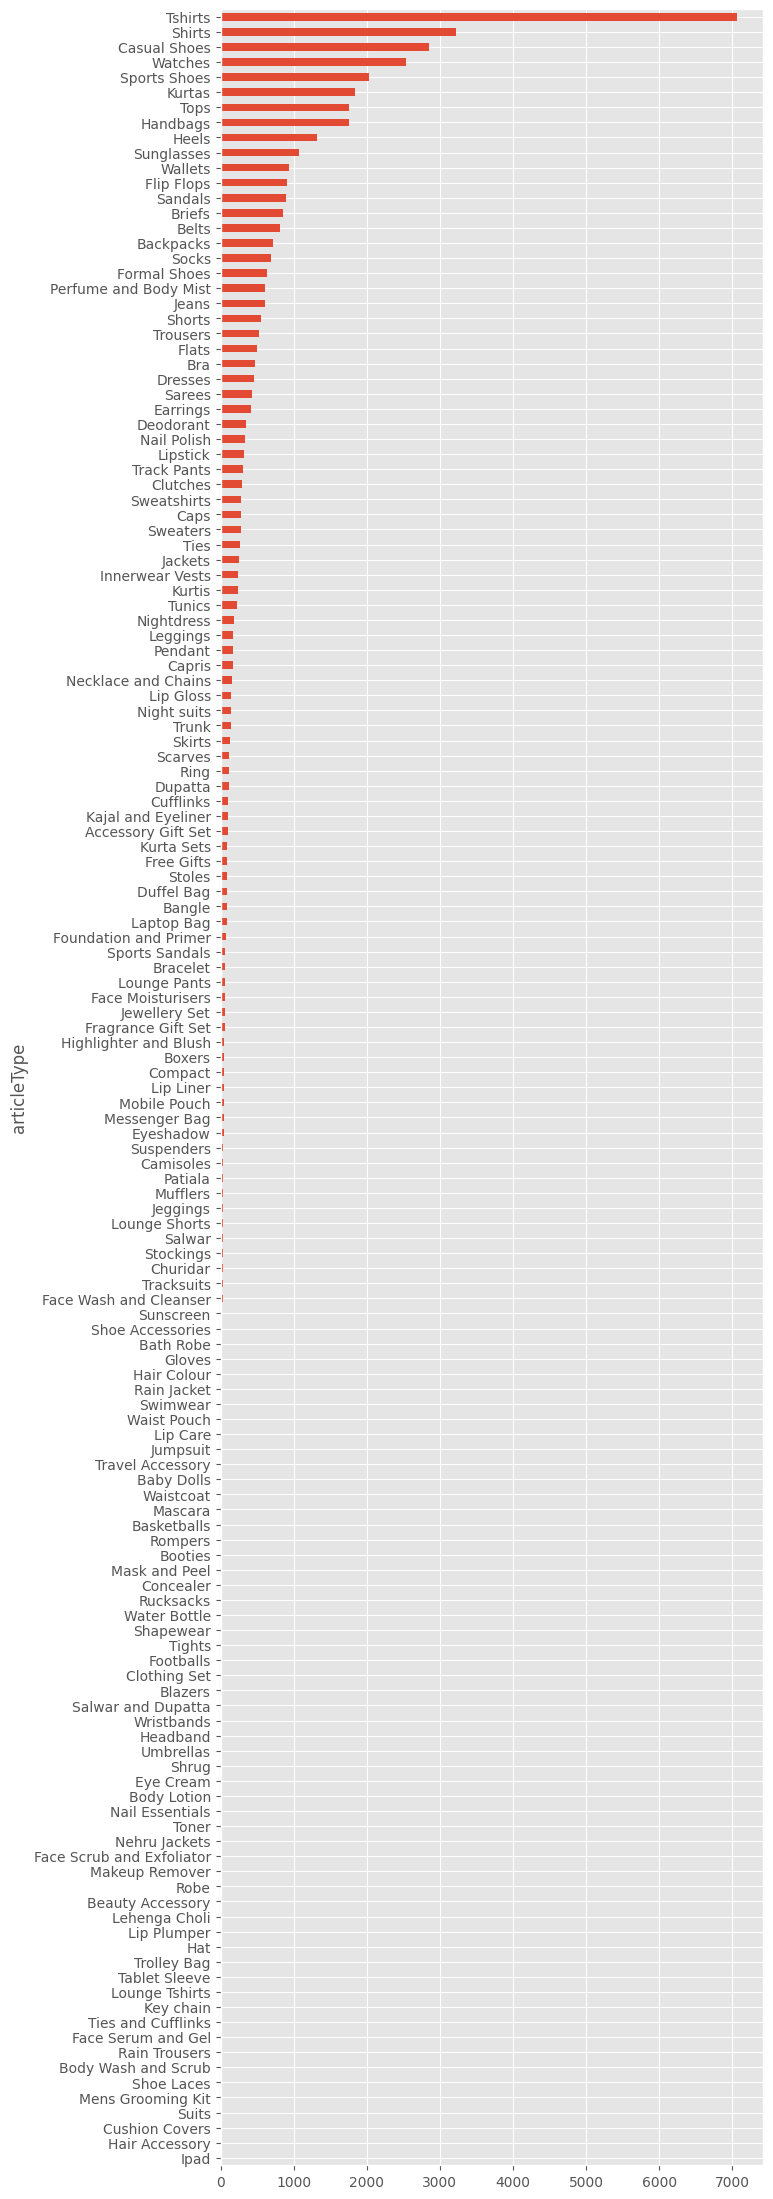

In [14]:
#set stype
plt.style.use('ggplot')

plt.figure(figsize=(7,28))
df.articleType.value_counts().sort_values().plot(kind='barh')


create a new column called imge, which will store the name of the image corresponding to that item's ID

In [25]:
#creating column to store image location ids
df['image'] = df.apply(lambda row: str(row['id']) + '.jpg', axis=1)

#reseting the index
df = df.reset_index(drop=True)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


We will create a function
in the next part of the code, which will help us easily obtain the path of
every image.

In [27]:
#image path
def image_location(img):
    return 'fashion-product-images-small/images/' + img

# function to load image
def import_img(image):
    image = cv2.imread(image_location(image))
    return image

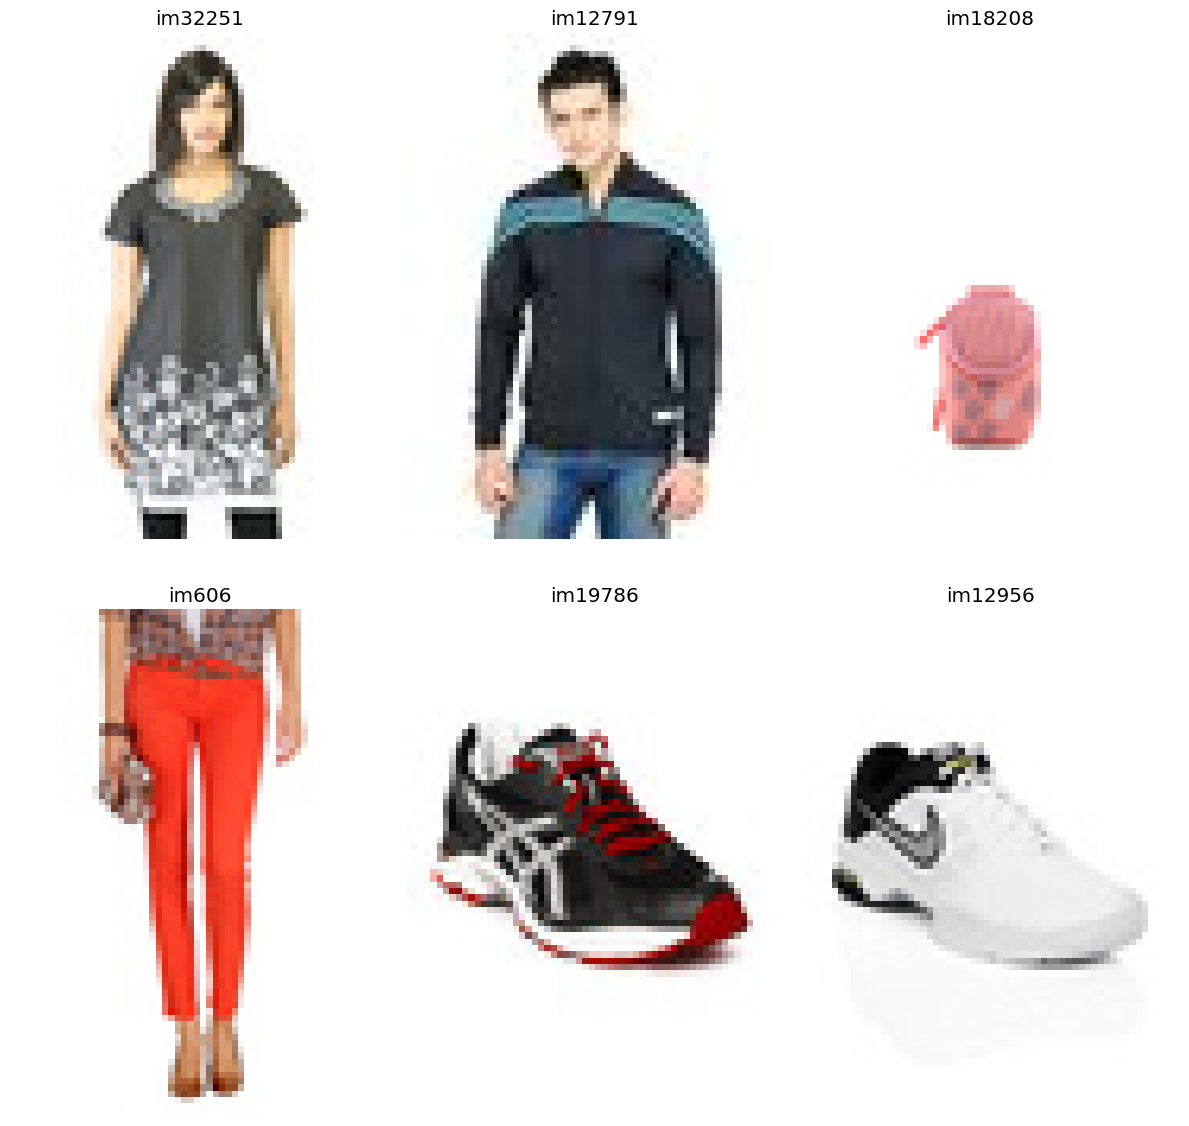

In [28]:
def show_images(images, rows= 1, cols=1, figsize=(12,12)):
    #define fig
    fig, axes = plt.subplots(ncols=cols, nrows=rows,figsize=figsize)
    
    #loop for images
    for index,name in enumerate(images):
        axes.ravel()[index].imshow(cv2.cvtColor(images[name],cv2.COLOR_BGR2RGB))
        axes.ravel()[index].set_title(name)
        axes.ravel()[index].set_axis_off()
    #plot
    plt.tight_layout()
    
#generation of a dictionary of {index, image}
figures =  {'im'+str(i): import_img(row.image) for i, row in df.sample(6).iterrows()}
#plotting the images in a figure, with 2 row and 3 columns 
show_images(figures, 2,3)

### Feature Engineering

#### ResNet18

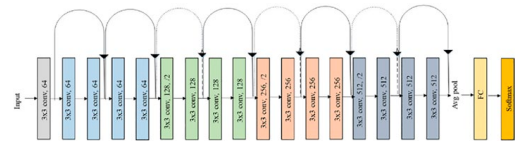

In [30]:
#Defining the input shape
width = 224
height = 224

#Loading the pretrained model
resnetmodel = models.resnet18(pretrained = True)

#selection the Layer
layer = resnetmodel._modules.get('avgpool')

#evaluation
resnetmodel.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import torch

# Load your model (make sure it's the correct ResNet version)
resnetmodel = models.resnet18(pretrained=True)
resnetmodel.eval()

# Define your transforms
resize_transform = transforms.Resize(224)
to_tensor_transform = transforms.ToTensor()
normalize_transform = transforms.Normalize(mean=[0.7, 0.6, 0.3], std=[0.2, 0.3, 0.1])

def vector_extraction(resnetmodel, image_id):
    try:
        img = Image.open(image_location(image_id)).convert('RGB')
        
        t_img = resize_transform(img)
        t_img = to_tensor_transform(t_img)
        t_img = normalize_transform(t_img)
        t_img = Variable(t_img.unsqueeze(0))  # Add batch dimension

        embeddings = torch.zeros(512)  # Placeholder for embeddings

        # Hook function adjusted for correct output dimensions
        def copy_data(m, i, o):
            o_reshaped = o.data.squeeze()  # Removes extra dimensions
            if o_reshaped.size(0) == 512:
                embeddings.copy_(o_reshaped)
            else:
                raise ValueError("Output size mismatch, expected 512 features but got size {}".format(o_reshaped.size(0)))

        # Register hook on the output of the adaptive average pooling layer
        hlayer = resnetmodel.avgpool.register_forward_hook(copy_data)

        # Forward pass
        resnetmodel(t_img)

        # Remove the hook
        hlayer.remove()

        return embeddings
    except FileNotFoundError:
        print(f"File not found: {image_location(image_id)}")
        return None

(80, 60, 3)
tensor([9.3482e-01, 8.1766e-01, 1.4271e-01, 1.5967e+00, 4.0310e-01, 9.9558e-01,
        6.0159e-01, 4.0231e-02, 1.3842e+00, 1.3105e+00, 2.4450e-01, 8.7519e-01,
        2.7396e-01, 3.2122e-01, 2.8277e-02, 1.1765e-01, 8.4165e-01, 9.9406e-02,
        5.3609e-02, 1.4799e+00, 8.7925e-01, 1.2959e+00, 2.4352e+00, 7.8503e-01,
        2.9830e-01, 7.1421e-02, 1.0809e+00, 2.8178e+00, 9.1848e-02, 7.0069e-01,
        6.0610e-01, 2.0370e-01, 1.2762e-01, 1.1411e+00, 9.1875e-01, 9.8947e-01,
        5.7651e-01, 2.9940e-01, 4.7863e-01, 1.0788e+00, 4.7155e-01, 1.2930e-01,
        1.6450e-01, 7.5288e-01, 1.6850e+00, 2.9922e-01, 4.4445e-01, 9.1466e-01,
        1.4365e+00, 8.1992e-01, 1.4908e+00, 6.8451e-01, 8.9888e-01, 4.2902e-01,
        6.0309e-01, 3.4448e-01, 2.4474e-01, 2.4668e+00, 7.2739e-01, 1.8283e+00,
        1.4422e-01, 4.3362e-01, 1.0285e+00, 1.1461e+00, 7.8070e-01, 2.3154e-01,
        7.4950e-01, 1.1186e+00, 1.1694e+00, 1.0016e+00, 4.8907e-01, 1.5443e+00,
        1.8048e-01, 5.2083e-

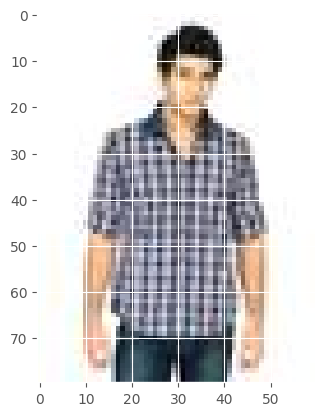

In [52]:
# Testing if out vector_extraction function works function works well on sample image

sample_embedding_0 =  vector_extraction(resnetmodel, df.iloc[0].image)
#plotting the sample image and its embeddings
img_array = import_img(df.iloc[0].image)

plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(sample_embedding_0)

(80, 60, 3)
tensor([1.7376e-01, 5.9528e-01, 8.3498e-01, 1.6554e+00, 1.1893e-01, 8.3752e-01,
        8.1816e-01, 8.0066e-02, 6.4129e-01, 1.1702e+00, 3.9105e-01, 8.0347e-01,
        1.6207e-01, 1.7394e-02, 6.8027e-02, 3.1306e-01, 4.1563e-01, 3.7957e-01,
        2.8381e-02, 2.2298e+00, 3.5374e-01, 6.7921e-01, 1.4892e+00, 6.3894e-01,
        4.0365e-01, 4.1202e-01, 6.6118e-01, 2.8892e+00, 0.0000e+00, 3.2388e-01,
        4.2013e-01, 7.9431e-02, 1.6844e-01, 2.0330e+00, 2.4609e+00, 3.0232e-01,
        4.7888e-01, 6.6369e-02, 6.7005e-01, 5.4278e-01, 2.7860e-01, 6.1910e-01,
        1.3525e-01, 2.5546e-01, 1.2090e+00, 1.7372e+00, 4.3966e-01, 8.3000e-02,
        1.6209e+00, 6.5620e-01, 1.9094e+00, 1.4417e+00, 2.4191e-01, 1.0142e+00,
        6.1233e-01, 9.8808e-01, 3.5287e-01, 1.5267e+00, 3.9435e-01, 3.6838e-01,
        1.6963e-01, 1.7560e-01, 1.9866e+00, 7.3262e-01, 5.4599e-01, 5.4618e-01,
        1.7577e+00, 4.1688e-02, 4.5372e-01, 9.9275e-01, 1.5127e+00, 1.1415e+00,
        3.8477e-01, 3.6211e-

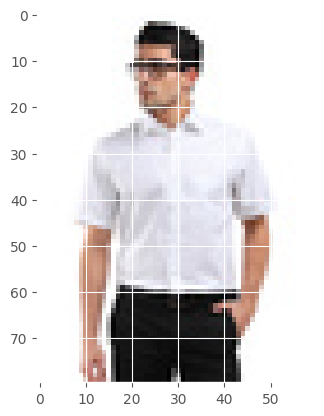

In [53]:
# Testing if our vector_extraction function works well on sample image

sample_embedding_1 = vector_extraction(resnetmodel, df.iloc[1000].image)

# Plotting the sample image and its embeddings
img_array = import_img(df.iloc[1000].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(sample_embedding_1)

In [54]:
# Finding the similarity between those two images

cos_sim = cosine_similarity(sample_embedding_0.unsqueeze(0),
                           sample_embedding_1.unsqueeze(0))

print("\nCosine similarity: {0}\n".format(cos_sim))




Cosine similarity: [[0.8732272]]



We have extracted the embeddings for only two images. Now let’s write
a loop and extract the vectors for all the images we have in our dataset.

In [56]:
%%time
import swifter

#Applying embeddings on subset of this hugt dataset
df_embeddings = df[:5000]
#We can apply on entire df, like:
#df_embeddings = df

#looping through images to get embeddings
map_embeddings = df_embeddings['image'].swifter.apply(lambda img: vector_extraction(resnetmodel,img))

#convert to series
df_embs = map_embeddings.apply(pd.Series)
print(df_embs.shape)
df_embs.head()

Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

(5000, 512)
CPU times: total: 18min 45s
Wall time: 10min 23s


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.934823,0.817656,0.142714,1.596721,0.403098,0.995577,0.601589,0.040231,1.384237,1.310480,...,0.363120,0.338541,1.860700,0.240637,0.050046,0.181791,1.276742,1.742215,0.045829,0.257625
1,0.735173,0.134385,0.327198,1.911102,0.433926,0.124787,0.586729,0.287877,0.652314,1.683377,...,0.203164,0.404689,0.002701,0.094407,0.007494,0.040532,0.707471,0.378482,0.092943,0.323599
2,0.242811,0.600202,2.845356,2.520746,0.104496,0.118218,2.399801,0.365963,2.305302,4.292481,...,0.333733,2.654163,0.941824,1.049012,0.333231,0.000000,1.422787,0.697803,0.014805,0.096200
3,0.802054,0.280661,0.648093,2.242340,0.287855,0.223903,1.005686,0.600974,0.336615,0.563953,...,0.199480,0.413048,0.077749,0.184160,0.000000,0.020647,0.643239,0.212560,0.004197,0.047895
4,0.811483,0.199352,0.434761,1.430864,0.123718,0.961154,0.601447,0.374916,2.456594,1.016216,...,0.462870,0.471510,1.094019,0.687342,0.205531,0.255458,0.800345,0.258945,0.044702,0.176974


In [58]:
#export the embeddings
df_embs.to_csv('df_embs.csv')

#importing the embeddings
df_embs = pd.read_csv('df_embs.csv')
# df_embs.drop(['Unnamed: 0','index'], axis=1, inplace= True)
# df_embs.dropna(inplace=True)
# Drop the columns and ignore errors if they don't exist
df_embs.drop(['Unnamed: 0', 'index'], axis=1, inplace=True, errors='ignore')
df_embs.dropna(inplace=True)

#exporting as pkl
joblib.dump(df_embs,'df_embs.pkl',9)

#importing th pkl
df_embs = joblib.load('df_embs.pkl')

### Calculating Similarity and Ranking

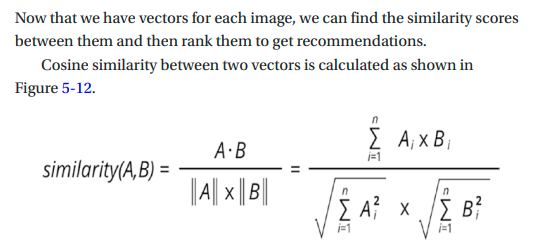

In [59]:
#Calculate similarith between images (using embedding values)
cosine_sim = cosine_similarity(df_embs)

#previewing fist 4 row and 4 columns similarity just to check th strcture of cosine_sim
cosine_sim[:4,:4]


array([[1.        , 0.75422188, 0.63587843, 0.76775521],
       [0.75422188, 1.        , 0.6484564 , 0.90431758],
       [0.63587843, 0.6484564 , 1.        , 0.66400801],
       [0.76775521, 0.90431758, 0.66400801, 1.        ]])

In [64]:
# Storing the index values in a series index_values for recommending
index_values = pd.Series(range(len(df)), index=df.index)
index_values

0            0
1            1
2            2
3            3
4            4
         ...  
44419    44419
44420    44420
44421    44421
44422    44422
44423    44423
Length: 44424, dtype: int64

In [71]:
# Storing the index values in a series index_values for recommending
index_values = pd.Series(range(len(df)), index=df.index)
index_values
# Defining a function that gives recommendations based on thecosine similarity score
def recommend_images(ImId, df, top_n =6):
    # Assigning index of reference into sim_ImId
    sim_ImId = index_values[ImId]
    
    # Storing cosine similarity of all other items with itemrequested by user in sml_scr as a list
    sml_scr = list(enumerate(cosine_sim[sim_ImId]))
    
    # Sorting the list of sml_scr
    sml_scr = sorted(sml_scr, key=lambda x: x[1], reverse=True)
    
    # Extracting the top n values from sml_scr
    sml_scr = sml_scr[1:top_n+1]
    
    # ImId_rec will return the index of similar items
    ImId_rec = [i[0] for i in sml_scr]
    
    # ImId_sim will return the value of similarity score
    ImId_sim = [i[1] for i in sml_scr]
    
    return index_values.iloc[ImId_rec].index, ImId_sim

In [72]:
# Sample given below
recommend_images(3810,df,top_n=5)

(Index([3899, 3459, 3678, 4384, 3967], dtype='int64'),
 [0.999998650581895,
  0.9999980928542745,
  0.9999979443945602,
  0.9999978564474437,
  0.9999976813738474])

# Visualizing the Recommendation

In [77]:
def Rec_viz_image(input_imageid):
    #Getting recommendation
    idx_rec, idx_sim = recommend_images(input_imageid, df, top_n = 6)
    
    #printing the similarity score
    print(idx_sim)
    
    #plotting the image of item requested by user
    plt.imshow(cv2.cvtColor(import_img(df.iloc[input_imageid].image),cv2.COLOR_BGR2RGB))
    
    #Generating a dixtionary of {index, image}
    figures =  {'im'+str(i): import_img(row.image) for i, row in df.loc[idx_rec].iterrows()}
    
    #Plotting the mililar images in a figure, wiwth 2 rows and 3 columns
    show_images(figures, 2, 3)

[0.999998650581895, 0.9999980928542745, 0.9999979443945602, 0.9999978564474437, 0.9999976813738474, 0.9999976416273567]


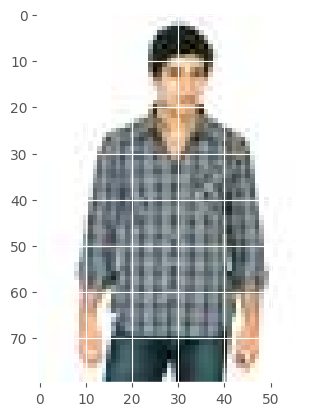

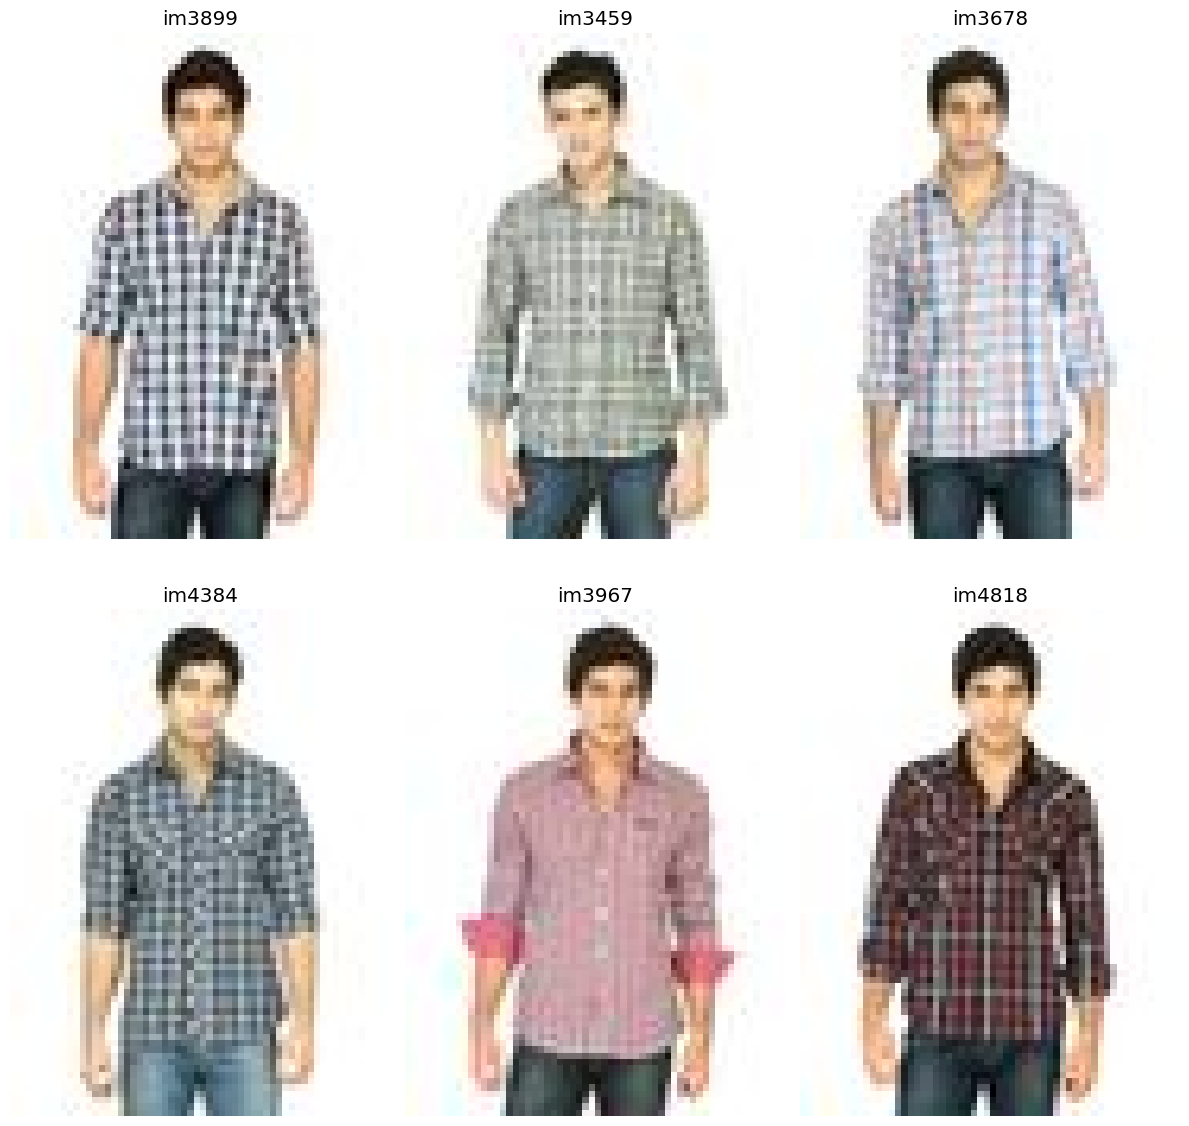

In [78]:
Rec_viz_image(3810)

[0.9999976358338571, 0.9999968726315478, 0.9999964777496663, 0.999996302474161, 0.9999957639527308, 0.9999949826204201]


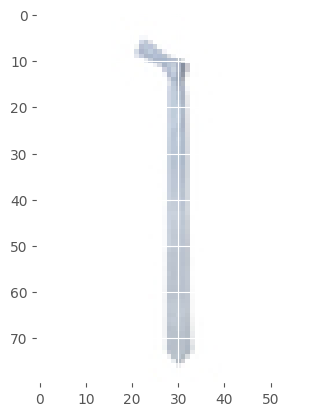

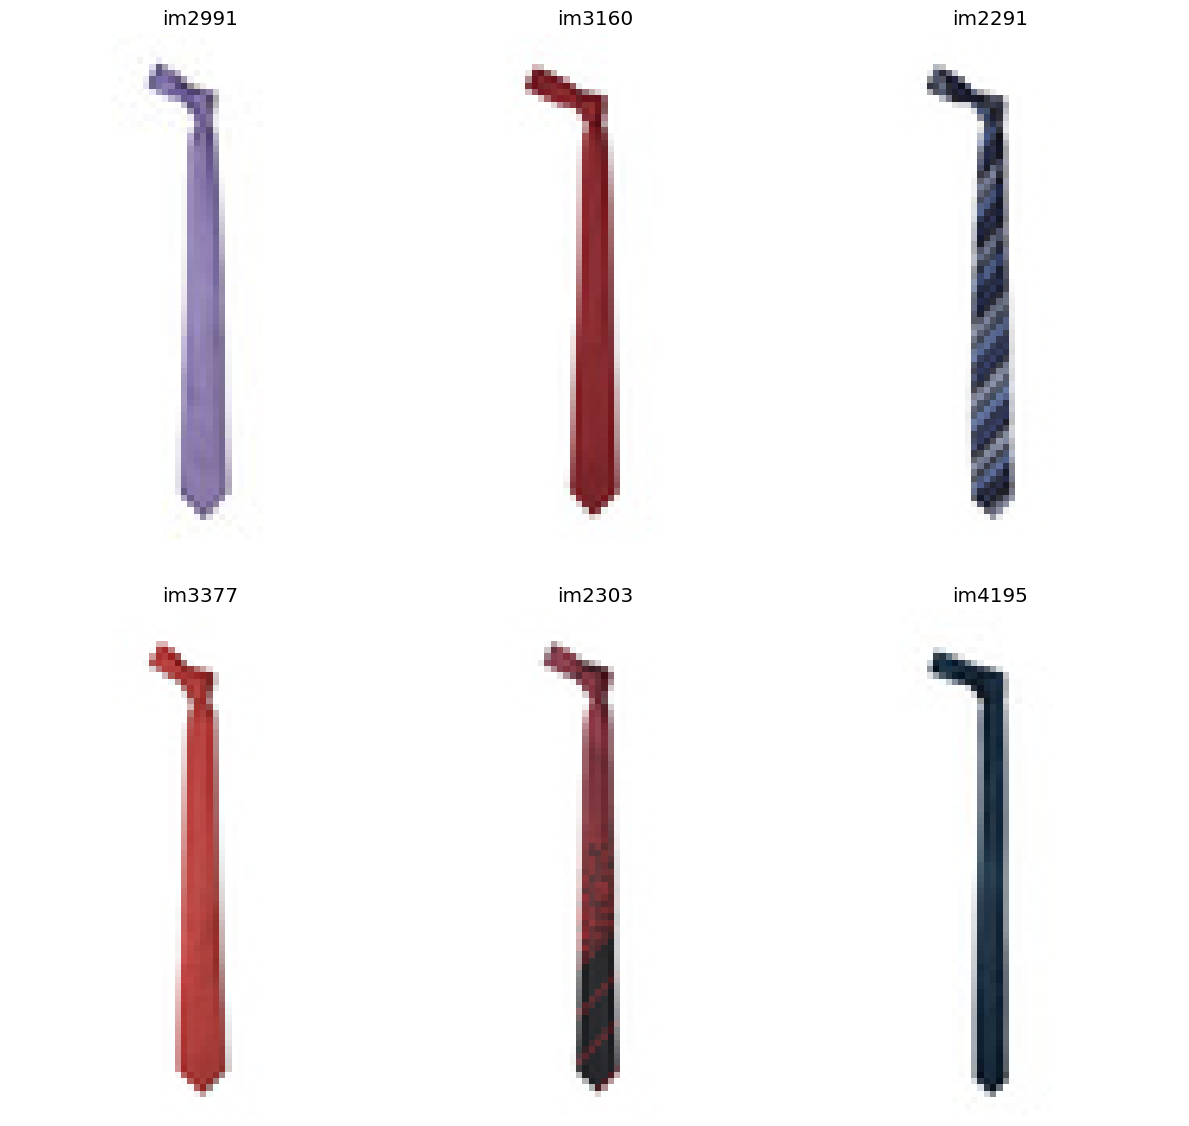

In [79]:
Rec_viz_image(2518)

### Taking Image input from Users and Recommending Similar Products

In [143]:
def recm_user_input(image_id):
    #Loading image and reshaping it
    img = Image.open('testset-for-image-similarity/' +image_id).convert('RGB')
    #t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
    t_img = resize_transform(img)
    t_img = to_tensor_transform(t_img)
    t_img = normalize_transform(t_img)
    t_img = Variable(t_img.unsqueeze(0))
    embeddings = torch.zeros(512)
    def copy_data(m, i, o):
        o_reshaped = o.data.squeeze()  # Removes extra dimensions
        if o_reshaped.size(0) == 512:
            embeddings.copy_(o_reshaped)
        else:
            raise ValueError("Output size mismatch, expected 512 features but got size {}".format(o_reshaped.size(0)))

    # Register hook on the output of the adaptive average pooling layer
    hlayer = resnetmodel.avgpool.register_forward_hook(copy_data)
#     def select_d(m, i, o):
#          embeddings.copy_(o.data.reshape(o.data.size(1)))
#     hlayer = layer.register_forward_hlayer(select_d)
    resnetmodel(t_img)
    hlayer.remove()
    emb = embeddings
    
    #calculating Cosine Similarity
    cs = cosine_similarity(emb.unsqueeze(0),df_embs)
    cs_list = list(flatten(cs))
    cs_df = pd.DataFrame(cs_list,columns=['Score'])
    cs_df = cs_df.sort_values(by=['Score'],ascending=False)

    # Printing Cosine Similarity
    print(cs_df['Score'][:10])
    
    # Extracting the index of top 10 similar items/images
    top10 = cs_df[:10].index
    top10 = list(flatten(top10))
    images_list = []
    for i in top10:
        image_id = df[df.index==i]['image']
        images_list.append(image_id)
        
    images_list = list(flatten(images_list))
    
    # Plotting the image of item requested by user
    plt.imshow(cv2.cvtColor(import_img(df.iloc[image_id].image),cv2.COLOR_BGR2RGB))
    #img_print = Image.open('testset-for-image-similarity/' + image_id)
    #img = Image.open(image_id).convert('RGB')
    #plt.imshow(cv2.cvtColor(img_print, cv2.COLOR_BGR2RGB))
    #plt.imshow(img)
    #plt.show()
    # Generating a dictionary { index, image }
    figures = {'im'+str(i): Image.open('fashionproduct-images-small/images/' + i) for i in images_list}
    
    # Plotting the similar images in a figure, with 2 rows and3 columns
    fig, axes = plt.subplots(2, 5, figsize = (8,8) )
    for index,name in enumerate(figures):
        axes.ravel()[index].imshow(figures[name])
        axes.ravel()[index].set_title(name)
        axes.ravel()[index].set_axis_off()
    plt.tight_layout()


In [144]:
print(df_embs.columns)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '502', '503', '504', '505', '506', '507', '508', '509', '510', '511'],
      dtype='object', length=512)


In [145]:
df_embs.drop(['Unnamed: 0', 'index'], axis=1, inplace=True, errors='ignore')
df_embs.dropna(inplace=True)
#df_embs = pd.read_csv('your_embeddings_file.csv')  # Load embeddings
recm_user_input('1525.jpg')  # Call function with df_embs


4780    0.889528
2395    0.886221
1153    0.883180
4196    0.878728
2824    0.873337
3747    0.865495
2651    0.864448
3113    0.863061
2420    0.839801
4419    0.839085
Name: Score, dtype: float64


ValueError: invalid literal for int() with base 10: '8377.jpg'

In [119]:
print(df_embs.columns)

Index(['Unnamed: 0.1', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '502', '503', '504', '505', '506', '507', '508', '509', '510', '511'],
      dtype='object', length=513)


In [102]:
#df_embs = df_embs.iloc[:, 1:]

In [121]:
df_embs = pd.read_csv('df_embs.csv')
def recm_user_input(image_id, df_embs):
    from PIL import Image
    import matplotlib.pyplot as plt
    from torch.autograd import Variable
    import torch
    from sklearn.metrics.pairwise import cosine_similarity
    import numpy as np

    # Load image and apply transformations
    img = Image.open('testset-for-image-similarity/' + image_id).convert('RGB')
    t_img = resize_transform(img)
    t_img = to_tensor_transform(t_img)
    t_img = normalize_transform(t_img)
    t_img = Variable(t_img.unsqueeze(0))
    embeddings = torch.zeros(512)

    def copy_data(m, i, o):
        o_reshaped = o.data.squeeze()
        if o_reshaped.size(0) == 512:
            embeddings.copy_(o_reshaped)
        else:
            raise ValueError("Output size mismatch, expected 512 features but got size {}".format(o_reshaped.size(0)))

    # Hook into the model
    hlayer = resnetmodel.avgpool.register_forward_hook(copy_data)
    resnetmodel(t_img)
    hlayer.remove()
    emb = embeddings.numpy()  # Convert tensor to NumPy array

    # Calculate cosine similarity
    cs = cosine_similarity(emb.reshape(1, -1), df_embs.values)
    cs_list = cs.flatten().tolist()
    cs_df = pd.DataFrame(cs_list, columns=['Score'])
    cs_df = cs_df.sort_values(by=['Score'], ascending=False)
    print(cs_df['Score'][:10])

    # Extract top 10 similar images
    top10 = cs_df[:10].index.tolist()
    images_list = [df[df.index == i]['image'].item() for i in top10]  # Make sure to access the actual image filename correctly

    # Plotting the input image
    img_print = Image.open('testset-for-image-similarity/' + image_id)
    plt.imshow(img_print)
    #plt.show()

    # Generating and plotting similar images
    figures = {'im'+str(i): Image.open('fashion-product-images-small/images/' + img) for i, img in enumerate(images_list)}
    fig, axes = plt.subplots(2, 5, figsize=(8, 8))
    for index, name in enumerate(figures):
        axes.ravel()[index].imshow(figures[name])
        axes.ravel()[index].set_title(name)
        axes.ravel()[index].set_axis_off()
    plt.tight_layout()
    plt.show()



In [122]:
print(df_embs.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7',
       ...
       '502', '503', '504', '505', '506', '507', '508', '509', '510', '511'],
      dtype='object', length=514)


In [114]:
df_embs.drop(['Unnamed: 0', 'index'], axis=1, inplace=True, errors='ignore')
df_embs.dropna(inplace=True)
#df_embs = pd.read_csv('your_embeddings_file.csv')  # Load embeddings
recm_user_input('1525.jpg', df_embs)  # Call function with df_embs


ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 512 while Y.shape[1] == 513